In [57]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


from warnings import filterwarnings
from tqdm import tqdm
import statsmodels.api as sm
filterwarnings('ignore')

# The Data Class

In [76]:
class DengueData:
    def __init__(self, impute=None, test_setsz=.2):

        features = pd.read_csv('../Data/dengue_features_train.csv')
        features.index = pd.DatetimeIndex(features.week_start_date)#.to_period("w")
        features.index = pd.MultiIndex.from_tuples(list(zip(*[features.city, features.index])), names=['city', 'week_start_date'])
        self.features = features[features.columns[4:]]
        self.labels = pd.read_csv('../Data/dengue_labels_train.csv', index_col=[0, 1, 2])
        self.labels.index = features.index
        self.n_features, self.n_samples = self.features.shape
        self.feat_train, self.labels_train, self.feat_test, self.labels_test = [None] * 4
        if impute is not None:
            self.impute_missing(method=impute)

    def impute_missing(self, method, add_indicator=False):
        '''
        Method for imputting missing data

        :param add_indicator:
        :param method: str; how to impute missing values
            pad / ffill: propagate last valid observation forward to next valid
            backfill / bfill: use next valid observation to fill gap.
            mean: fill with the mean value of the feature
            median: fill with median value of the feature
            KNN: optimized K-nearest neighbors
        :return:
        '''
        if add_indicator:
                self.features = self.features.join(self.features.isna().astype(float), rsuffix='_miss')
        if method in ['backfill', 'bfill', 'pad', 'ffill']:
            self.features.fillna(method=method, inplace=True)
        elif method == 'mean':
            self.features.fillna(value=self.features.mean(axis=0), inplace=True)
        elif method == 'median':
            self.features.fillna(value=self.features.median(axis=0), inplace=True)
        elif method == 'linear':
            self.features.interpolate(method='linear', axis=0, inplace=True)
        elif method == 'time':
            X = self.features
            idx = X.index
            X.reset_index(drop=True, inplace=True)
            X.index=idx.get_level_values('week_start_date')
            X.interpolate(method='time', axis=0, inplace=True)
            X.index = idx
            self.features = X

        elif method == 'quadratic' | 'cubic':
            X = self.features
            idx = X.index
            X.reset_index(drop=True, inplace=True)
            X.interpolate(method=method, axis=0, inplace=True)
            X.index = idx
            self.features = X

        else:
            rmse = lambda actual, yhat: np.sqrt(mean_squared_error(actual, yhat))
            errors = {'K':[], 'RMSE':[]}
            for k in range(1, 20, 2):
                imputer = KNNImputer(n_neighbors=k, weights='distance')
                imputed = pd.DataFrame(imputer.fit_transform(self.features))
                feat_train, labels_train, feat_test, labels_test = self.split_train_test(x=imputed)
                model = RandomForestRegressor()
                model.fit(feat_train, labels_train.to_numpy().ravel())
                preds = model.predict(feat_test)
                error = rmse(labels_test, preds)
                errors['K'].append(k)
                errors['RMSE'].append(error)
            df_k = pd.DataFrame(errors)
            k = int(df_k.loc[df_k['RMSE'].idxmin()]['K'])
            imputer = KNNImputer(n_neighbors=k, weights='distance')
            self.features =  pd.DataFrame(imputer.fit_transform(self.features), columns = list(self.features.columns), index=self.features.index)

    def split_train_test(self, inplace=False, append_labels=False, intercept=False, x=None, y=None, city=None,  test_setsz=.2):
        '''
        splits features into training and test sets.
        '''

        if x is None:
            x = self.features
        if y is None:
            y = self.labels
        if intercept:
            x.insert(loc=0, column="Intercept", value=1)

        if city is not None:
            x = x.loc[city]
            y = y.loc[city]

        feat_train = x.iloc[:int(np.floor(len(x) * (1 - test_setsz)))]
        feat_test = x.iloc[:int(np.floor(len(x) * test_setsz))]

        labels_train = y.iloc[:int(np.floor(len(y) * (1 - test_setsz)))]
        labels_test = y.iloc[:int(np.floor(len(y) * test_setsz))]

        if append_labels:
            feat_train['total_cases'] = labels_train.total_cases.values
            feat_test['total_cases'] = labels_test.total_cases.values

        if inplace:
            self.feat_train, self.labels_train, self.feat_test, self.labels_test = [feat_train, labels_train, feat_test, labels_test]
            return
        else:
            return feat_train, labels_train, feat_test, labels_test

    def plot_case_dist(self):
        sns.displot(x='total_cases', col='city', data=self.labels);
        pass

    def plot_cases(self):
        sns.relplot(x=self.features.index.get_level_values(1), y=self.labels.total_cases, col=self.features.index.get_level_values(0), kind='line');

    def principle_components(self, n_pc, city=None, plotting=True):
        if city is not None:
            xx = self.features.loc[city]
        else:
            xx = self.features
        X_scaled = StandardScaler().fit_transform(xx)


        pc_list = ["PC"+str(i) for i in list(range(1, n_pc+1))]
        # Decompose
        pca = PCA(n_components=n_pc)
        self.feat_pc = pd.DataFrame(data=pca.fit_transform(X_scaled), columns=pc_list, index=xx.index)
        #finalDf = pd.concat([self.feat_pc, pd.Series(Y.total_cases.values, name='total_cases')], axis=1)
        skree_df = pd.DataFrame({'unexplained variance': pca.explained_variance_ratio_, 'PC':pc_list})
        total_var_exp = np.cumsum(pca.explained_variance_ratio_)

        # Attribute loadings onto PCs
        loadings = pca.components_
        #num_pc = pca.n_features_
        loadings_df = pd.DataFrame.from_dict(dict(zip(pc_list, abs(loadings))))
        loadings_df['variable'] = self.features.columns
        loadings_df.set_index('variable', inplace=True)
        loadings_df.sort_values(pc_list, ascending=False, inplace=True)
        if plotting:
            f, ax = plt.subplots(figsize=(20, 7), ncols=2)
            sns.pointplot(x='PC', y="unexplained variance", data=skree_df, color="c", ax=ax[1])
            sns.heatmap(loadings_df, ax=ax[0])
            ax[0].set_title("Loading")
            ax[1].set_title("Skree - Unexplained Variance")


# Negative Binomial
## with all features

In [123]:

for mtd in ['mean', 'median','linear','quadratic', 'cubic', 'time', 'bfill', 'ffill', 'KNN']:
    errs = []
    for cc in ['sj', 'iq']:
        dat = DengueData(impute=mtd)
        feat_train, labels_train, feat_test, labels_test = dat.split_train_test(city=cc, intercept=True)
        formula = 'total_cases ~ + 1 '+" ".join(['+ '+v for v in feat_train.columns])
        nb_train_result = sm.GLM(endog=labels_train , exog=feat_train, family=sm.families.NegativeBinomial(alpha=1)).fit()
        test_preds = nb_train_result.get_prediction(feat_test).predicted_mean
        errs.append(abs(labels_test.total_cases - test_preds))
    print(f'imput method: {mtd}, error: {errs[0].append(errs[1]).mean()}')



imput method: mean, error: 19.044282658935586
imput method: median, error: 18.690662151615673
imput method: linear, error: 17.71938222450332
imput method: quadratic, error: 18.853352605659406
imput method: cubic, error: 18.751615571548236
imput method: time, error: 18.71570174695307
imput method: bfill, error: 18.31706072520119
imput method: ffill, error: 17.186355125778164
imput method: KNN, error: 18.850879908948304


## with Principle Componnents

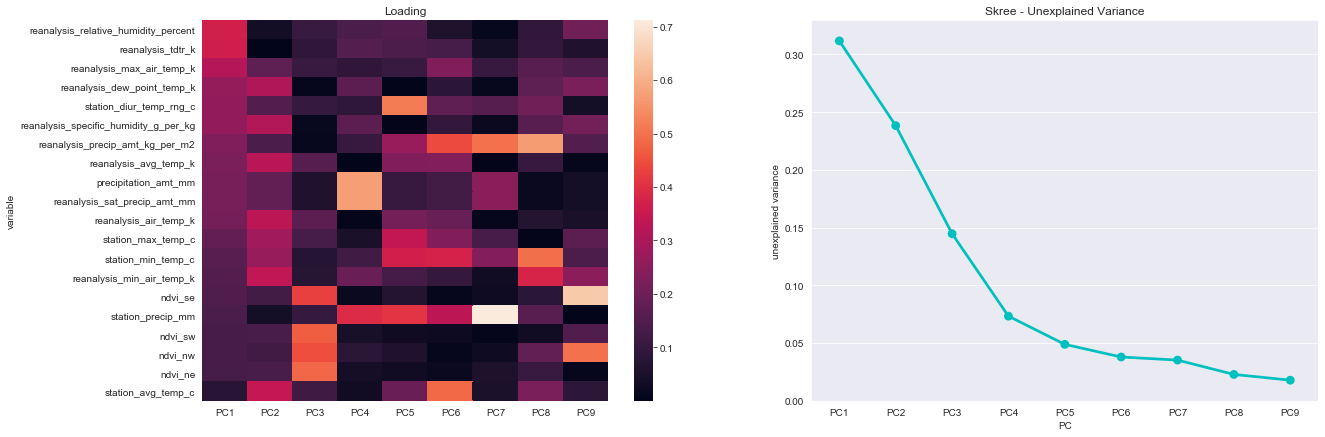

In [109]:
dat = DengueData(impute='ffill')
dat.principle_components(n_pc=9, city='iq')

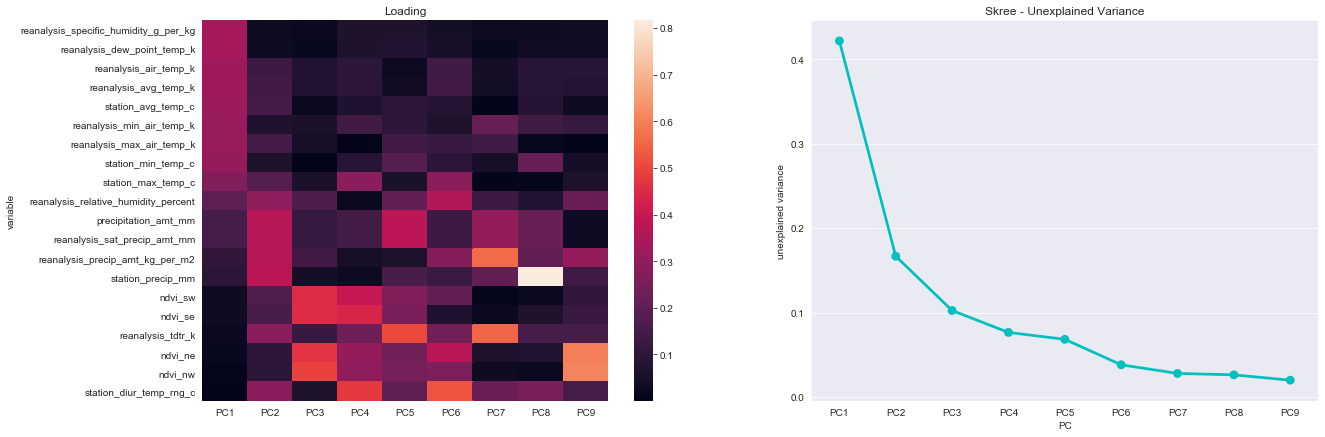

In [110]:
dat = DengueData(impute='ffill')
dat.principle_components(n_pc=9, city='sj')

In [130]:
for mtd in ['mean', 'median','linear', 'bfill', 'ffill', 'KNN']:
    errs = []
    for cc, npc in zip(['sj', 'iq'], [4, 5]):
        dat = DengueData(impute=mtd)
        dat.principle_components(n_pc=npc, city=cc, plotting=False)
        pc_x_train, pc_y_train, pc_x_test, pc_y_test = dat.split_train_test(x=dat.feat_pc, y=dat.labels.loc[cc], intercept=True)
        formula = 'total_cases ~ + 1 '+" ".join(['+ '+v for v in pc_x_train.columns])
        nb_train_result = sm.GLM(endog=pc_y_train , exog=pc_x_train, family=sm.families.NegativeBinomial(alpha=1)).fit()
        test_preds = nb_train_result.get_prediction(pc_x_test).predicted_mean
        errs.append(abs(pc_y_test.total_cases - test_preds))
    print(f'imput method: {mtd}, error: {errs[0].append(errs[1]).mean()}')


imput method: mean, error: 17.90257044979426
imput method: median, error: 17.781942437140724
imput method: linear, error: 17.64023535089563
imput method: bfill, error: 18.150991136411786
imput method: ffill, error: 17.193141705103987
imput method: KNN, error: 17.420085961168603


# AR models

In [114]:
dat = DengueData(impute='ffill')

x_train, y_train, x_test, y_test = dat.split_train_test(city='sj', intercept=True)


## Testing for stationarity

In [131]:
from statsmodels.tsa.stattools import adfuller
#Ho: It is non stationary
#H1: It is stationary

result = adfuller(y_train['total_cases'])
labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
for value,label in zip(result,labels):
    print(label+' : '+str(value) )
if result[1] <= 0.05:
    print("P value is less than 0.05 that means we can reject the null hypothesis(Ho). Therefore we can conclude that data has no unit root and is stationary")
else:
    print("Weak evidence against null hypothesis that means time series has a unit root which indicates that it is non-stationary ")

ADF Test Statistic : -6.650077901931195
p-value : 5.1473186737591e-09
#Lags Used : 9
Number of Observations Used : 926
P value is less than 0.05 that means we can reject the null hypothesis(Ho). Therefore we can conclude that data has no unit root and is stationary


In [ ]:
sm.tsa.statespace.SARIMAX

In [51]:
errs = []
for cc in ['sj', 'iq']:
    dat = DengueData(impute='ffill')
    x_train, y_train, x_test, y_test = dat.split_train_test(city=cc, intercept=True)
    for df in [x_train, y_train, x_test, y_test]:
        df.reset_index(inplace=True)
        df.index = pd.DatetimeIndex(df.week_start_date).to_period('W')
        df.drop('week_start_date', inplace=True, axis=1)
    ARMAmodel = sm.tsa.statespace.SARIMAX(endog=y_train, exog=x_train,  order=(1,0, 1))
    res = ARMAmodel.fit()
    # generating predictions
    y_pred = res.predict(start=y_test.index[0], end=y_test.index[-1])
    errs.append(abs(y_pred.values - y_test.total_cases.values))

print(f'ARMA method error: {np.concatenate(errs).mean()}')


ARMA method error: 10.917481722101632


In [135]:
preds = []
for cc in ['sj', 'iq']:
    dat = DengueData(impute='ffill')
    #x_train = dat.features
    #y_train = dat.labels
    x_train, y_train, x_test, y_test = dat.split_train_test(city=cc, intercept=True, test_setsz=0)

    x_test = pd.read_csv('../Data/dengue_features_test.csv', index_col=[0, 1, 2])

    x_test = x_test.loc[cc]

    for df in [x_train, y_train, x_test]:
        df.reset_index(inplace=True)
        df.index = pd.DatetimeIndex(df.week_start_date).to_period('W')
        df.drop('week_start_date', inplace=True, axis=1)
    wk = x_test[['year', 'weekofyear']]
    x_test.drop(['year', 'weekofyear'], axis=1, inplace=True)
    x_test.fillna(method='ffill', inplace=True)
    x_test.insert(loc=0, column="Intercept", value=1)

    ARMAmodel = sm.tsa.statespace.SARIMAX(endog=y_train, exog=x_train,  order=(1,0, 1))
    res = ARMAmodel.fit()
    # generating predictions
    y_pred = res.forecast(steps=len(x_test), exog=x_test)  #res.predict(start=x_test.index[0], end=x_test.index[-1], exog=x_test)
    preds.append(y_pred)

In [147]:
#np.concatenate(errs)
#errs[1].shape
def make_submission(preds, filename):
    """
    preds is a list of length 2, (one for each city) of pandas Series.
    Each series contains the output of the prediction
    """
    x_test = pd.read_csv('../Data/dengue_features_test.csv', index_col=[0, 1, 2])
    xx = preds[0].append(preds[1])
    xx.reset_index(drop=True, inplace=True)
    xx.index = x_test.index
    xx = pd.DataFrame(xx)
    xx.rename(columns={'predicted_mean': 'total_cases'}, inplace=True)
    xx.total_cases = [int(round(tc)) for tc in xx.total_cases]
    xx.to_csv('../Data/'+filename, sep=',')
    return


week_start_date   ndvi_ne   ndvi_nw   ndvi_se   ndvi_sw  \
city year weekofyear                                                           
sj   2008 18              2008-04-29 -0.018900 -0.018900  0.102729  0.091200   
          19              2008-05-06 -0.018000 -0.012400  0.082043  0.072314   
          20              2008-05-13 -0.001500       NaN  0.151083  0.091529   
          21              2008-05-20       NaN -0.019867  0.124329  0.125686   
          22              2008-05-27  0.056800  0.039833  0.062267  0.075914   
...                              ...       ...       ...       ...       ...   
iq   2013 22              2013-05-28  0.301471  0.380029  0.280629  0.383186   
          23              2013-06-04  0.247600  0.296343  0.285371  0.350357   
          24              2013-06-11  0.238729  0.251029  0.252586  0.249771   
          25              2013-06-18  0.310429  0.302700  0.406614  0.403943   
          26              2013-06-25  0.339467  0.240071  0.356943  0.273600   

                      precipitation_amt_mm  reanalysis_air_temp_k  \
city year weekofyear                                                
sj   2008 18                         78.60             298.492857   
          19                         12.56             298.475714   
          20                          3.66             299.455714   
          21                          0.00             299.690000   
          22                          0.76             299.780000   
...                                    ...                    ...   
iq   2013 22                         41.12             297.774286   
          23                         71.52             297.167143   
          24                         78.96             295.831429   
          25                         39.54             295.778571   
          26                         51.80             297.372857   

                      reanalysis_avg_temp_k  reanalysis_dew_point_temp_k  \
city year weekofyear                                                       
sj   2008 18                     298.550000                   294.527143   
          19                     298.557143                   294.395714   
          20                     299.357143                   295.308571   
          21                     299.728571                   294.402857   
          22                     299.671429                   294.760000   
...                                     ...                          ...   
iq   2013 22                     298.964286                   295.638571   
          23                     298.328571                   295.845714   
          24                     296.607143                   294.894286   
          25                     297.400000                   293.648571   
          26                     299.000000                   294.615714   

                      reanalysis_max_air_temp_k  ...  \
city year weekofyear                             ...   
sj   2008 18                              301.1  ...   
          19                              300.8  ...   
          20                              302.2  ...   
          21                              303.0  ...   
          22                              302.3  ...   
...                                         ...  ...   
iq   2013 22                              305.5  ...   
          23                              306.3  ...   
          24                              304.6  ...   
          25                              305.9  ...   
          26                              307.3  ...   

                      reanalysis_precip_amt_kg_per_m2  \
city year weekofyear                                    
sj   2008 18                                    25.37   
          19                                    21.83   
          20                                     4.12   
          21                                     2.20   
          22          

In [96]:
wk = x_test[['year', 'weekofyear']]
x_test.drop(['year', 'weekofyear'], axis=1, inplace=True)


In [98]:
x_test.fillna(method='ffill', inplace=True)
x_test

,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
week_start_date,,,,,,,,,,,,,,,,,,,,
2008-04-28/2008-05-04,-0.0189,-0.0189,0.102729,0.0912,78.6,298.492857,298.55,294.527143,301.1,296.4,25.37,78.781429,78.6,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2
2008-05-05/2008-05-11,-0.018,-0.0124,0.082043,0.072314,12.56,298.475714,298.557143,294.395714,300.8,296.7,21.83,78.23,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3
2008-05-12/2008-05-18,-0.0015,ffill,0.151083,0.091529,3.66,299.455714,299.357143,295.308571,302.2,296.4,4.12,78.27,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0
2008-05-19/2008-05-25,ffill,-0.019867,0.124329,0.125686,0.0,299.69,299.728571,294.402857,303.0,296.9,2.2,73.015714,0.0,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3
2008-05-26/2008-06-01,0.0568,0.039833,0.062267,0.075914,0.76,299.78,299.671429,294.76,302.3,297.3,4.36,74.084286,0.76,16.137143,3.542857,27.614286,7.085714,33.3,23.3,84.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-03-25/2013-03-31,-0.0874,-0.016183,0.156343,0.105186,30.34,298.67,298.885714,294.675714,301.3,296.4,2.55,78.78,30.34,15.985714,3.314286,27.542857,7.942857,33.9,22.8,3.5
2013-04-01/2013-04-07,-0.20325,-0.077833,0.204171,0.178914,6.55,298.035714,298.157143,294.628571,301.5,295.9,64.3,81.65,6.55,15.881429,2.828571,26.642857,6.642857,33.3,22.8,17.6
2013-04-08/2013-04-14,-0.1176,-0.0082,0.1927,0.170429,0.0,299.057143,299.328571,294.948571,301.5,297.5,0.7,78.285714,0.0,16.212857,3.171429,27.914286,8.114286,32.8,23.3,9.4


In [21]:
'''import requests
from io import BytesIO

# Dataset
wpi1 = requests.get('https://www.stata-press.com/data/r12/wpi1.dta').content
data = pd.read_stata(BytesIO(wpi1))
data.index = data.t
#Set the frequency
data.index.freq="QS-OCT"
# Fit the model
mod = sm.tsa.statespace.SARIMAX(data['wpi'], trend='c', order=(1,0,1))
res = mod.fit(disp=False)
print(res.summary())'''

                               SARIMAX Results                                
Dep. Variable:                    wpi   No. Observations:                  124
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -172.610
Date:                Thu, 21 Jul 2022   AIC                            353.221
Time:                        16:23:16   BIC                            364.502
Sample:                    01-01-1960   HQIC                           357.804
                         - 10-01-1990                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0438      0.427      0.103      0.918      -0.794       0.882
ar.L1          0.9994      0.006    172.091      0.000       0.988       1.011
ma.L1          0.5628      0.072      7.848      0.0

In [87]:
a = res.get_prediction()

In [20]:
data

,wpi,t,ln_wpi
t,,,
1960-01-01,30.700001,1960-01-01,3.424263
1960-04-01,30.799999,1960-04-01,3.427515
1960-07-01,30.700001,1960-07-01,3.424263
1960-10-01,30.700001,1960-10-01,3.424263
1961-01-01,30.799999,1961-01-01,3.427515
...,...,...,...
1989-10-01,109.400002,1989-10-01,4.695011
1990-01-01,111.000000,1990-01-01,4.709530
1990-04-01,110.800003,1990-04-01,4.707727


In [43]:
labels_train

,total_cases
week_start_date,
1990-04-30,4
1990-05-07,5
1990-05-14,4
1990-05-21,3
1990-05-28,6
...,...
2004-08-12,14
2004-08-19,14
2004-08-26,7
